In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# attack_type = 'none'
# datasets = 'pokec_n pokec_z credit bail dblp'.split()
datasets = 'pokec_n pokec_z dblp'.split()
models = 'gcn'.split()
df_results = pd.DataFrame()
for dataset in datasets:
    for model in models:
        for ptb_rate in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
            for attack_type in 'fair_attack prbcd dice random'.split():
                for target in 'y1s0 y1s1'.split():
                    for connection_type in 'DD'.split() if attack_type=='fair_attack' else ['None']:
                        c_attack_type = attack_type
                        if ptb_rate == 0: c_attack_type = 'none'
                        fname = f'../../results/result-{dataset}-{model}-{c_attack_type}' + ('' if c_attack_type=='none' else (f'-{ptb_rate:.2f}' if c_attack_type!='fair_attack' else f'-{target}-{connection_type}-deg0-null-{ptb_rate:.2f}')) +'.csv'
                        if not os.path.exists(fname):
                            fname = f'../../results/result-{dataset}-region-{model}-{c_attack_type}' + ('' if c_attack_type=='none' else (f'-{ptb_rate:.2f}' if c_attack_type!='fair_attack' else f'-{target}-{connection_type}-deg0-null-{ptb_rate:.2f}')) +'.csv'
                        if not os.path.exists(fname):
                            print(f'File not found: {fname}')
                            continue
                        df_current = pd.read_csv(fname)
                        df_current['dataset'] = dataset
                        df_current['model'] = model
                        df_current['attack_type'] = attack_type
                        df_current['ptb_rate'] = ptb_rate
                        df_current['Strategy']=connection_type
                        df_current['Target'] = target
                        df_results = pd.concat([df_results, df_current], ignore_index=True)

In [3]:
df_results.columns

Index(['acc', 'auc', 'precision', 'recall', 'maf1', 'mif1', 'yp1.a1', 'yp1.a0',
       'yp1.y1a1', 'yp1.y1a0', 'yp1.y0a1', 'yp1.y0a0', 'parity', 'equality',
       'eq_odds', 'dataset', 'model', 'attack_type', 'ptb_rate', 'Strategy',
       'Target'],
      dtype='object')

In [4]:
df_results['err_y1s1'] = 1-df_results['yp1.y1a1']
df_results['err_y0s0'] = df_results['yp1.y0a0']
df_results['err_y1s0'] = 1-df_results['yp1.y1a0']
df_results['err_y0s1'] = df_results['yp1.y0a1']

In [5]:
df_results['signed_parity'] = df_results['yp1.y0a0'] + df_results['yp1.y1a0'] - df_results['yp1.y1a1'] - df_results['yp1.y0a1']

In [6]:
df_results.loc[df_results.attack_type=='iter1','attack_type'] = 'MH-BFS'
df_results.loc[df_results.attack_type=='iter2','attack_type'] = 'MH-DFS'
df_results.loc[df_results.attack_type=='iter3','attack_type'] = 'MH-DFS-Rand'

In [7]:
df_results['Category'] = '_'

In [8]:
df_results.loc[df_results.attack_type=='dice','Category'] = 'Accuracy-targeting'
df_results.loc[df_results.attack_type=='random','Category'] = 'Baseline'
df_results.loc[df_results.attack_type=='prbcd','Category'] = 'Accuracy-targeting'
df_results.loc[df_results.attack_type=='fair_attack','Category'] = 'Ours'

In [9]:
df_results.loc[df_results.attack_type=='spih','attack_type'] = 'Inject+'
df_results.loc[df_results.attack_type=='spih-rev','attack_type'] = 'Inject-'
df_results.loc[df_results.attack_type=='rspis','attack_type'] = 'AnchorRewire+'
df_results.loc[df_results.attack_type=='rspis-rev','attack_type'] = 'AnchorRewire-'
df_results.loc[df_results.attack_type=='rspis2','attack_type'] = 'Rewire+'
df_results.loc[df_results.attack_type=='rspis-rev2','attack_type'] = 'Rewire-'
df_results.loc[df_results.attack_type=='sacide','attack_type'] = 'SA-CIDE'
df_results.loc[df_results.attack_type=='dice','attack_type'] = 'DICE'
df_results.loc[df_results.attack_type=='random','attack_type'] = 'Random'
df_results.loc[df_results.attack_type=='prbcd','attack_type'] = 'PR-BCD'

In [10]:
df_results.loc[(df_results.attack_type=='fair_attack') & (df_results.Target=='y1s1'),'attack_type'] = 'y1s1-DD'
df_results.loc[(df_results.attack_type=='fair_attack') & (df_results.Target=='y1s0'),'attack_type'] = 'y1s0-DD'

In [11]:
df_results['Attack'] = df_results.attack_type

In [12]:
df_results['attack'] = df_results.attack_type.apply(lambda x:x[:-1] if (x[-1] in '-+') else x)
df_results['direction'] = df_results.attack_type.apply(lambda x:x[-1] if (x[-1] in '-+') else '0')

In [13]:
df_results['_']=''

In [14]:
sns.set_style('whitegrid')

In [26]:
dataset_map = {'pokec_n':'Pokec_n', 'pokec_z':'Pokec_z', 'dblp':'DBLP'}

In [27]:
df_results['Dataset'] = df_results.dataset.apply(lambda x:dataset_map[x])

In [28]:
df_results['attack'].unique()

array(['y1s0-DD', 'y1s1-DD', 'PR-BCD', 'DICE', 'Random'], dtype=object)

<Figure size 432x288 with 0 Axes>

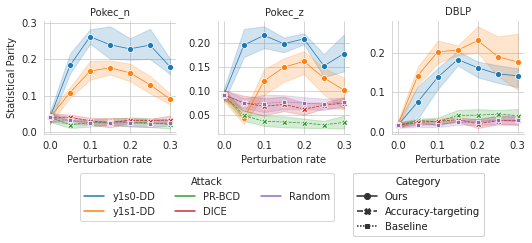

In [30]:
# for dataset in datasets:
# print('=======================' +  dataset + '=======================')
# for measure in 'parity err_y0s0 err_y0s1 err_y1s0 err_y1s1 acc'.split():
measure = 'parity'
plt.figure()
g = sns.FacetGrid(df_results, col='Dataset', sharey=False, height=2.5)
# for atks in [df_results.Attack.unique()[:2],['PR-BCD'],['DICE','Random']]:
#     print(atks)
g.map(sns.lineplot,'ptb_rate', measure,'Attack','_','Category', markers=True)
g.set_titles('{col_name}')
g.set_axis_labels("Perturbation rate", "Statistical Parity")
handles, labels = g.axes[0,-1].get_legend_handles_labels()
l1 = plt.legend(bbox_to_anchor=(-3.4, -.45, 4, .102), loc='upper center',
                ncol=3, borderaxespad=0.,handles=handles[1:6],labels=labels[1:6],title='Attack')
g.axes[0,-1].add_artist(l1)

l2 = plt.legend(bbox_to_anchor=(-1.8, -.45, 4, .102), loc='upper center',
                ncol=1, borderaxespad=0.,handles=handles[7:],labels=labels[7:],title='Category')
g.axes[0,-1].add_artist(l2)

plt.savefig(f'../../reports/figures/{measure}-comparison.pdf', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

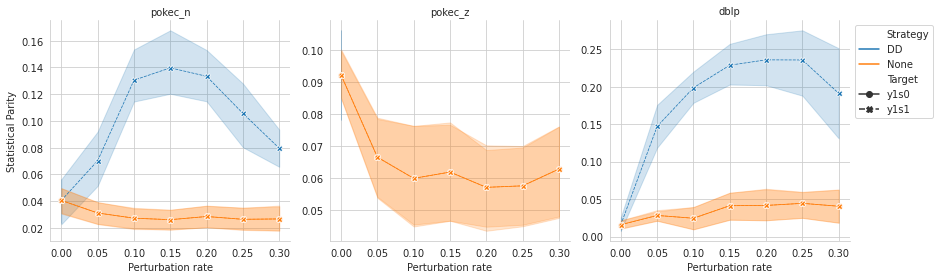

In [44]:
# for dataset in datasets:
# print('=======================' +  dataset + '=======================')
# for measure in 'parity err_y0s0 err_y0s1 err_y1s0 err_y1s1 acc'.split():
measure = 'parity'
plt.figure()
g = sns.FacetGrid(df_results, col='dataset', row='model', sharey=False, height=4)
g.map(sns.lineplot,'ptb_rate', measure, 'Strategy', '_', 'Target', markers=True)
g.set_titles('{col_name}')
g.set_axis_labels("Perturbation rate", "Statistical Parity")
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.savefig(f'../../reports/figures/{measure}.pdf', bbox_inches='tight')


In [ ]:
# for dataset in datasets:
# print('=======================' +  dataset + '=======================')
# for measure in 'parity err_y0s0 err_y0s1 err_y1s0 err_y1s1 acc'.split():
measure = 'parity'
plt.figure()
g = sns.FacetGrid(df_results, col='dataset', row='model', sharey=False, height=4)
g.map(sns.lineplot,'ptb_rate', measure, 'Strategy', '_', 'Target', markers=True)
g.set_titles('{col_name}')
g.set_axis_labels("Perturbation rate", "Statistical Parity")
plt.legend(bbox_to_anchor=(-2, -.3, 2.5, .102), loc='upper left',
                      ncol=8, mode="expand", borderaxespad=0.)
plt.savefig(f'../../reports/figures/{measure}.pdf', bbox_inches='tight')
